In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.constants import c
from scipy.fftpack import rfft
c = c.value*1e-6 #Speed of light in mm/ns
import peakdetect
import scipy.optimize as op
# import scipy.optimize as op
# from scipy.interpolate import interp1d
# from scipy.optimize import curve_fit

In [2]:
T = 0.9763
R = 0.0234
A = 0.0003
L = 2.25*25.4
nu_fsr = c/(2*L)
print nu_fsr

2.62285615048


In [3]:
nu = np.r_[140:160:50000j] # Range of frequencies of interest
F = 4*R/(1-R)**2
delta = 2*np.pi*nu/nu_fsr
P = (T/(1-R))**2*1./(1 + F*np.sin(delta/2)**2)

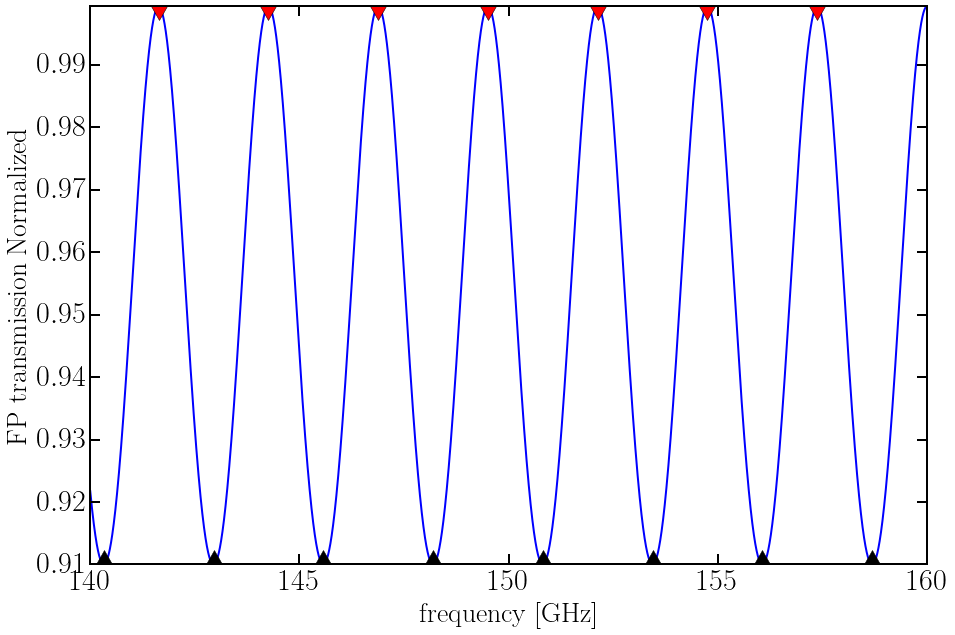

In [4]:
max_peaks, min_peaks = peakdetect.peakdetect(P,nu, lookahead=200)
max_nu,max_P = map(list, zip(*max_peaks))
min_nu, min_P = map(list, zip(*min_peaks))
max_indices = np.searchsorted(nu, max_nu)
min_indices = np.searchsorted(nu, min_nu)

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(nu, P, 'b')
ax.plot(max_nu, max_P, 'rd', markersize=20)
ax.plot(min_nu, min_P, 'kd', markersize=20)
ax.axis('tight')
ax.set_xlabel('frequency [GHz]')
ax.set_ylabel('FP transmission Normalized');

In [29]:
def transmissionModel(nu, *theta):
    # Fits for the first n terms of a fourier series for a period equal to 1.
    """
    Returns the n term fourier series expansion of a function which has a period of 1 in x and has the fourier
    coefficients listed in theta. The last component of theta is a the fundamental period of the oscillations.
    """
    assert (len(theta)%2)==0, "The length of theta must be even"
    n = len(theta)/2 - 1# Remember n isn't the length of the array.It is the number of terms in the fourier expansion.
#     b0 = theta[0]
#     c_k = theta[1:n+1] - to get n terms!!!!
#     s_k = theta[n+1:] - to get n terms!!!!
    # Lambda functions for each term in the fourier series
    fsr = theta[-1]
    c_k = theta[1:n+1]
    s_k = theta[n+1:-1]
    x = nu/fsr
    index = np.arange(1,n+1)
    fourier_cterm = lambda ck, k: ck*np.cos(2*np.pi*x*k)
    fourier_sterm = lambda sk, k: sk*np.sin(2*np.pi*x*k)
    
    return theta[0] + np.sum(map(fourier_cterm, c_k, index),axis=0)+\
    np.sum(map(fourier_sterm, s_k, index),axis=0)
    
def lnlike(theta, x, y, yerr):
    model = transmissionModel(x, *theta)
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2))

In [7]:
# Initializing the parameters
n = 3
# R = 0.02
fsr =c/(2*L)
# T = 0.98
b0 = (T/(1-R))**2*((1-R)/(1+R))
print b0
k = np.arange(1,n+1)
b_k = 2*R**k*b0
c_k = b_k
s_k = [0]*n
guesses = [b0] +list(c_k) + list(s_k)
# guesses[-1] = b0

b0_guess = guesses[0]
bk_guess = (np.array(guesses)[1:n+1]**2 + np.array(guesses)[n+1:]**2)**0.5

0.95368388915


In [15]:
#Let's see if using the likelihood function will be more useful
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, guesses, args=(nu, P,np.ones_like(P)), method='Powell')
#                      bounds=[(0,1.0), (0,1.0),(0.0*scans['L'],5.0*scans['L']),(None, None)])
# R_ml, T_ml, L_ml, phi_ml = result["x"]
# print result['x']
print result['message']
chisq =  lnlike(result['x'],nu,P,np.ones_like(P) )
print chisq

b0_MLE = result['x'][0]
bk_MLE = (result['x'][1:n+1]**2 + result['x'][n+1:]**2)**0.5
phik_MLE = np.arctan2(result['x'][n+1:], result['x'][1:n+1])
print b0_MLE

Optimization terminated successfully.
-4.08251423323e-09
0.953683889511


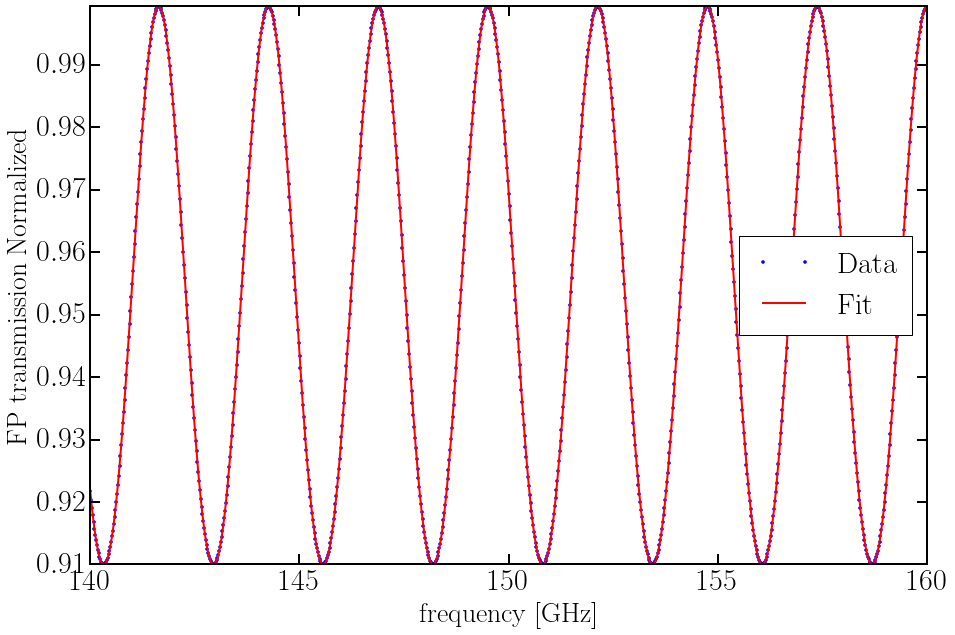

In [21]:
# Use the max peaks to determine the range used in the fourier fitting
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(nu[::50], P[::50], 'b.', label='Data')
ax.plot(nu, transmissionModel(nu, *result['x']),'r', label='Fit')
ax.axis('tight')
ax.legend(loc='best')
ax.set_xlabel('frequency [GHz]')
ax.set_ylabel('FP transmission Normalized');

In [22]:
index = np.arange(1, (len(P)+1)/2)
# print len(index)
# N = len(P[mask])
# print N
# y = rfft(P[mask])/N
# b0 = y[0]
# y*=2
# c_k = y[1:N:2]
# s_k = y[2:N:2]
# b_k = (c_k**2 + s_k**2)**0.5
# nu_0k = np.arctan2(s_k, c_k)/2/np.pi

In [23]:
# fourier_cterm = lambda ck, k: ck*np.cos(2*np.pi*nu/nu_fsr*k)
# fourier_sterm = lambda sk, k: sk*np.sin(2*np.pi*nu/nu_fsr*k)
#Let's try and get the FP fringes using the series expansion
A = (T/(1-R))**2*((1-R)/(1 + R))
R_k = R**index
# P_series = A*(1 + 2*np.sum(map(fourier_cterm, R_k, index),axis=0))

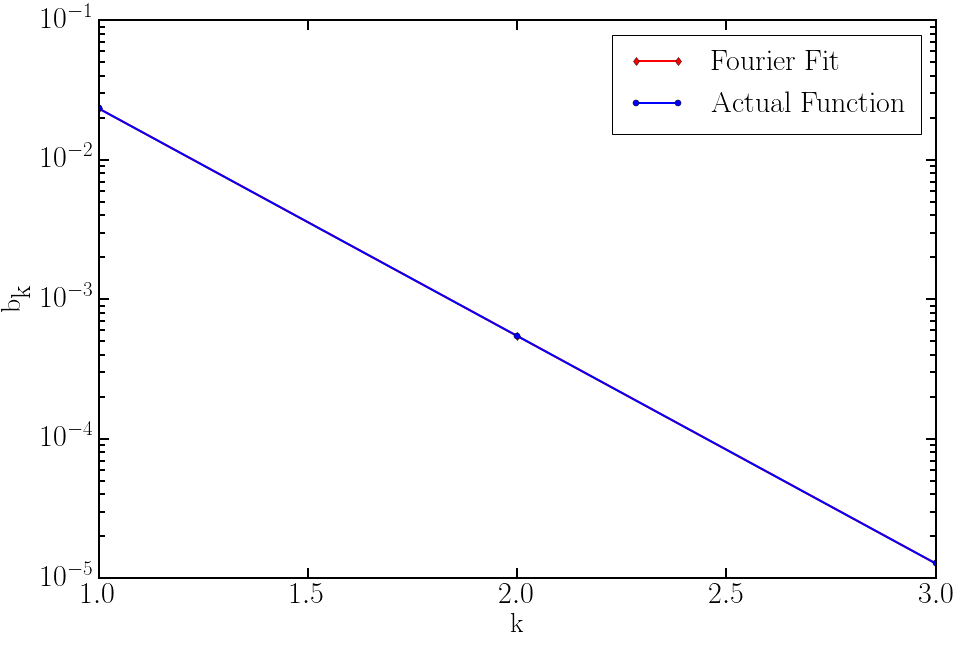

In [28]:
fig, ax = plt.subplots(figsize=(15,10))
ax.semilogy(index[:n], bk_MLE/(2*b0_MLE), 'rd-', label='Fourier Fit')
ax.semilogy(index[:n], R_k[:n], 'bo-', label='Actual Function')
# ax.set_xlim(0.0, 20)
# ax.axis('tight')
ax.set_xlabel('k')
ax.legend(loc='best')
ax.set_ylabel(r'$\textrm{b}_{\textrm{k}}$');

In [ ]:
P_fseries = b0 + np.sum(map(fourier_cterm, c_k, index),axis=0) + np.sum(map(fourier_sterm, s_k, index),axis=0)
error = P - P_fseries

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(nu, P, 'b', label='FP Model')
ax.plot(nu, P_fseries, 'r', label='Fourier Series')
ax.axis('tight')
ax.set_xlabel('frequency [GHz]')
ax.set_ylabel('FP transmission Normalized');
ax.legend(loc='best')

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(nu, error)  # Fourier Coefficients 
ax.plot(max_nu, error[max_indices], 'rd', markersize=20, label='Maxima of FP')
ax.plot(min_nu, error[min_indices], 'kd', markersize=20, label='Minima of FP')
# ax.axis('tight')
ax.set_xlabel('k')
ax.set_yticklabels(['%1.2g' %t for t in ax.get_yticks()]);
ax.set_ylabel('Error')
ax.legend(loc='best')
print np.average(error**2)**0.5

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(nu, P, 'b')
ax.plot(nu, P_series, 'r')
ax.axis('tight')
ax.set_xlabel('frequency [GHz]')
ax.set_ylabel('FP transmission Normalized');

In [ ]:
# Let's see if the fourier coefficients reproduce R
R_try = (b_k/(2*b0))**(1./index)
fig, ax = plt.subplots(figsize=(15,10))
ax.stem(index[:10], R_try[:10])
ax.hlines(R, 0, 10.0, colors=u'k')
ax.set_xlim(0.0, 10.0)
# ax.axis('tight')
ax.set_xlabel('k')
ax.set_ylabel(r'Estimates of R');

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.stem(index, c_k/(2*b0), 'r')  # Fourier Coefficients 
ax.stem(index, R_k, 'b')
ax.set_xlim(0.0, 10.0)
# ax.axis('tight')
ax.set_xlabel('k')
ax.set_ylabel(r'$\textrm{c}_{\textrm{k}}$');

In [ ]:
ratio = R_k/(c_k/(2*b0))
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(index, ratio, 'r')  
ax.set_xlim(0.0, 10.0)
# ax.axis('tight')
ax.set_xlabel('k')
ax.set_ylabel(r'Ratio');

In [ ]:
index2 = np.arange(len(P[mask]))
y = rfft(error[mask])/N
fig, ax = plt.subplots(figsize=(15,10))
ax.stem(index2, y.real, 'b')  # Fourier Coefficients 
# ax.stem(index2, y.imag, 'b')
ax.set_xlim(0.0, 10.0)
# ax.axis('tight')
ax.set_xlabel('k');

In [ ]:
len(index)

In [ ]:
ax.stem?

In [ ]:
c_k[10]

In [ ]:
y = np.array([0,1,2,3,4,5,6,7,8,9,10])
y[1:-1:2]

In [ ]:
print y[1:11:2]
print y[2:11:2]
len(index)

In [ ]:
y[1:11:2]

In [ ]:
np.linspace?